# Model Creation

In this notebook, we will process the data and train our final model to classify cancellations.


---

**Dependencies**

Check `requirements.txt`

Main:
* ipykernel
* pandas
* sckit-learn
* azureml-sdk
* xgboost

### Libraries

In [13]:
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

### Load data

In [4]:
%load_ext kedro.ipython

[05/31/25 21:17:49] INFO     Using 'c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo               __init__.py:272
                             semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\kedro\f                
                             ramework\project\rich_logging.yml' as logging configuration.                          

                    INFO     Registered line magic '%reload_kedro'                                   __init__.py:63

                    INFO     Registered line magic '%load_node'                                      __init__.py:65

                    INFO     Resolved project path as: c:\Users\Esteban\Documents\. Clases_Tec\8.   __init__.py:180
                             Octavo semestre\_Proyecto\kProject\tcaproject.                                        
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/31/25 21:17:55] WARNING  c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo                      ]8;id=720227;file://C:\Users\Esteban\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=696063;file://C:\Users\Esteban\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\mlflow\                
                             pyfunc\utils\data_validation.py:186: UserWarning: [33mAdd type hints                  
                             to the `predict` method to enable data validation and automatic                       
                             signature inference during model logging. Check                                       
                             https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage                
                             -in-pythonmodel for more details.[0m                                                  
                               color_warning(                                                                      
                                                                                                                   

                    INFO     Registering new custom resolver: 'km.random_name'                    mlflow_hook.py:65

                    WARNING  No 'mlflow.yml' config file found in environment. Default            mlflow_hook.py:78
                             configuration will be used. Use ``kedro mlflow init`` command in CLI                  
                             to customize the configuration.                                                       

                    INFO     The 'tracking_uri' key in mlflow.yml is relative            kedro_mlflow_config.py:293
                             ('server.mlflow_(tracking|registry)_uri = mlruns'). It is                             
                             converted to a valid uri:                                                             
                             'file:///C:/Users/Esteban/Documents/.%20Clases_Tec/8.%20Oct                           
                             avo%20semestre/_Proyecto/kProject/tcaproject/mlruns'                                  

[05/31/25 21:17:56] INFO     Kedro is sending anonymous usage data with the sole purpose of improving plugin.py:233
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

                    INFO     Kedro project tcaProject                                               __init__.py:146

                    INFO     Defined global variable 'context', 'session', 'catalog' and            __init__.py:147
                             'pipelines'                                                                           

[05/31/25 21:17:57] INFO     Registered line magic 'run_viz'                                        __init__.py:153

In [23]:
%reload_kedro

[31/05/2025 09:43:37 p. m.] INFO     Resolved project path as: C:\Users\Esteban\Documents\.         __init__.py:180
                                     Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject.                  
                                     To set a different path, run '%reload_kedro <project_root>'                   

[31/05/2025 09:43:38 p. m.] INFO     Registering new custom resolver: 'km.random_name'            mlflow_hook.py:65

                            WARNING  No 'mlflow.yml' config file found in environment. Default    mlflow_hook.py:78
                                     configuration will be used. Use ``kedro mlflow init``                         
                                     command in CLI to customize the configuration.                                

                            INFO     Kedro is sending anonymous usage data with the sole purpose of   plugin.py:233
                                     improving the product. No personal data or IP addresses are                   
                                     stored on our side. If you want to opt out, set the                           
                                     `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment                       
                                     variables, or create a `.telemetry` file in the current working               
                                     directory with the contents `consent: false`. Read more at                    
                                     https://docs.kedro.org/en/stable/configuration/telemetry.html                 

[31/05/2025 09:43:39 p. m.] INFO     Kedro project tcaProject                                       __init__.py:146

                            INFO     Defined global variable 'context', 'session', 'catalog' and    __init__.py:147
                                     'pipelines'                                                                   

                            INFO     Registered line magic 'run_viz'                                __init__.py:153

In [24]:
df = catalog.load("reservaciones_cleaned")  # type: ignore # noqa: F821
df.shape

[31/05/2025 09:43:40 p. m.] INFO     Loading data from reservaciones_cleaned                    data_catalog.py:403
                                     (ParquetDataset)...                                                           

(202491, 49)

In [25]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 202491 entries, 0 to 203001
Columns: 49 entries, id_reservaciones to cliente_disp_anio_anterior
dtypes: bool(3), datetime64[ns](5), float64(2), int64(24), object(15)
memory usage: 73.2+ MB


In [26]:
df.head()

,id_reservaciones,fecha_hoy,fecha_reservacion,fecha_llegada,fecha_salida,numero_personas,numero_personas_anio_anterior,numero_adultos,numero_adultos_anio_anterior,numero_menores,...,nombre_estatus_reservacion,clave_estado,nombre_estado,total_tarifa,id_moneda,fecha_ultimo_cambio,reservacion,reservacion_anio_anterior,id_cliente_disp,cliente_disp_anio_anterior
0,0,2019-08-16,2019-08-16,2019-07-11,2019-10-11,2,0,2,0,0,...,Salida,Emx,México,2659.98,1,2019-10-11,True,False,2,0
1,1,2019-10-22,2019-10-22,2019-01-12,2019-05-12,4,0,4,0,0,...,Salida,Egt,Guanajuato,1764.00,1,2019-05-12,True,False,4,0
2,2,2019-10-28,2019-10-28,2019-01-12,2019-05-12,2,0,2,0,0,...,Salida,Emc,Michoacán,2660.04,1,2019-05-12,True,False,2,0
3,3,2019-10-28,2019-10-28,2019-08-12,2019-11-12,4,0,3,0,0,...,Salida,Egt,Guanajuato,1995.03,1,2019-11-12,True,False,3,0
4,4,2019-10-28,2019-10-28,2019-08-12,2019-12-12,2,0,2,0,0,...,Salida,Emx,México,13369.92,1,2019-12-12,True,False,2,0


### Data Processing

#### 0. Target Variable

Definition of target varable (cancelacion)

In [28]:
df_tv = df.copy() # Copy of last dataset

df_tv['cancelacion'] = df_tv["nombre_estatus_reservacion"].apply(lambda x: 1 if x == 'Reservacion Cancelada' else 0)

# Value counts of target variable
df_tv['cancelacion'].value_counts()


cancelacion
0    169194
1     33297
Name: count, dtype: int64

#### 1. Filter variables

Filter the variables that will be used by the model.

In [29]:
model_variables =['nombre_paquete',
                  'ciudad_agencia',
                  'nombre_tipo_habitacion',
                  'nombre_canal',
                  'nombre_estado',
                  #'hist_menores',
                  #'hist_total_habitaciones'
                  ]

# Model variables and target variable
df_fv = df_tv.copy()[model_variables+['cancelacion']]

df_fv.head()

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado,cancelacion
0,Walk In ...,Mexico City ...,Estd 2Q Sn12Mst,Multivacaciones 2,México,0
1,Ninguno ...,Mexico City ...,Estd 2Q Sn12Mst,Multivacaciones 2,Guanajuato,0
2,Walk In ...,Mexico City ...,Jr Suite 1K Sn12Mjs,Multivacaciones 2,Michoacán,0
3,Ninguno ...,Mexico City ...,Jr Suite 2Q Sn12Mjs,Multivacaciones 2,Guanajuato,0
4,Walk In ...,Cancún ...,Luxury 2Q Sn12Gsu,Vertical Booking ...,México,0


#### 3. Transform categorical variables

In [30]:
df_tcv = df_fv.copy()

# Subset of dataset containing only records with canceled reservations
df_cancelations = df_tcv[df_tcv.cancelacion == 1]


# Function
def calcular_peso_columna(dfx, columna, nombre_columna_resultado=None):
    # Usar nombre_columna_resultado o columna si no se especifica
    nombre_columna_resultado = nombre_columna_resultado or columna

    # Calcular conteos de valores únicos (convertidos a string para evitar problemas con tipos mixtos)
    conteos = dfx[columna].astype(str).value_counts()

    # Crear DataFrame resultado directamente desde la Serie conteos
    peso = conteos.rename_axis(nombre_columna_resultado).reset_index(name='conteo')

    # Calcular proporción en porcentaje con 3 decimales
    peso['proporcion'] = (peso['conteo'] / peso['conteo'].sum()).round(4)

    return peso


# Diccionario con pesos para cada columna, limpiando '#_' del nombre para la clave
pesos = {
    f"peso_{col}": calcular_peso_columna(dfx=df_cancelations, columna=col)
    for col in model_variables
}

# Convertir pesos a diccionario json
dict_pesos = {k: v.to_dict(orient='records') for k, v in pesos.items()}


# Reemplaza los valores en el df con los pesos asignados a cada variable del diccionario
for col in model_variables:
    nombre_peso = f"peso_{col}"

    if nombre_peso in pesos:
        # Mapear valores directamente usando Series para mejor rendimiento
        #mapa = pesos[nombre_peso].set_index(col)['proporcion']
        mapa = pd.Series({item[col]: item['proporcion'] for item in dict_pesos[nombre_peso]})
        df_tcv[col] = df_tcv[col].astype(str).map(mapa)


df_tcv.head()

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado,cancelacion
0,0.8825,0.3008,0.0899,0.1630,0.0689,0
1,0.1174,0.3008,0.0899,0.1630,0.0331,0
2,0.8825,0.3008,0.0489,0.1630,0.0812,0
3,0.1174,0.3008,0.0240,0.1630,0.0331,0
4,0.8825,0.1286,0.2974,0.0184,0.0689,0


**Save dict_pesos as json**

In [31]:
# Clean extra spaces in the dictionary
def limpiar_espacios(obj):
    if isinstance(obj, dict):
        return {k: limpiar_espacios(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [limpiar_espacios(elem) for elem in obj]
    elif isinstance(obj, str):
        # Elimina espacios extra entre palabras y al inicio/final
        return ' '.join(obj.split())
    else:
        return obj

dict_pesos_clean = limpiar_espacios(dict_pesos)

In [32]:
# save dict_json as json file with asci encoding
with open("pesos_variables.json", "w", encoding="utf-8") as f:
    import json
    json.dump(dict_pesos_clean, f, ensure_ascii=False, indent=4)

**Test read dict_pesos json file and update categorical columns for testing**

In [10]:
# Test read dict_pesos json file and update categorical columns for testing
with open('pesos_variables.json', 'r') as f:
    dict_pesos = json.load(f)

# Test dataset    
df_json_test = df_fv.copy()


# Update categorical columns in df_tcv with the weights from dict_pesos
for col in model_variables:
    col_name = "peso_"+col
    if col_name in dict_pesos:
        # Mapear valores directamente usando Series para mejor rendimiento
        mapa = pd.Series({item[col]: item['proporcion'] for item in dict_pesos[col_name]})
        df_json_test[col] = df_json_test[col].astype(str).map(mapa)
        
df_json_test.fillna(0, inplace=True)  # Fill NaN values with 0
        
df_json_test.head()

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado,cancelacion
0,0.8824,0.3009,0.0899,0.1630,0.0689,0
1,0.1174,0.3009,0.0899,0.1630,0.0331,0
2,0.8824,0.3009,0.0489,0.1630,0.0812,0
3,0.1174,0.3009,0.0240,0.1630,0.0331,0
4,0.8824,0.1286,0.2973,0.0184,0.0689,0


In [11]:
pd.DataFrame(dict_pesos["peso_nombre_paquete"])

,nombre_paquete,conteo,proporcion
0,Walk In,29385,0.8824
1,Ninguno,3910,0.1174
2,Entre Semana,4,0.0001
3,Fin De Semana,2,0.0001


In [12]:
dict_pesos["peso_nombre_paquete"][0]

{'nombre_paquete': 'Walk In', 'conteo': 29385, 'proporcion': 0.8824}

*df_cancelations don't have all the values that has df_tcv; this "label encoding" may fail*

### Model

In [13]:
df_model = df_tcv.copy()

df_model.dropna(axis=0, inplace=True)
df_model.isna().sum().sum()

0

**Split variables**

In [14]:
X = df_model[model_variables]
y = df_model["cancelacion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(159857, 5)
(159857,)
(39965, 5)
(39965,)


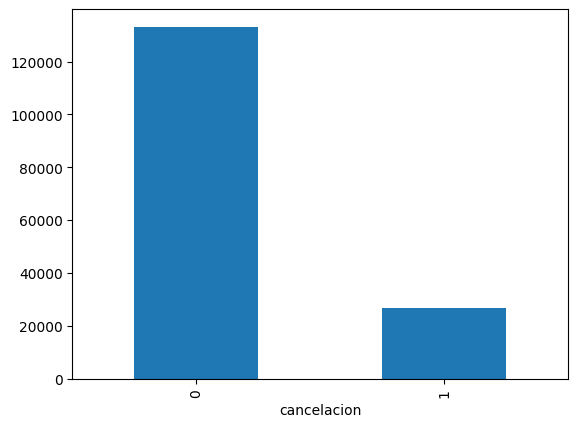

In [15]:
y_train.value_counts().plot.bar();

**Train and evaluate**

In [16]:
# Entrenar el modelo
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))



c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\Modelo - Javier\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.97      0.90      0.93     33365
           1       0.62      0.88      0.73      6600

    accuracy                           0.89     39965
   macro avg       0.80      0.89      0.83     39965
weighted avg       0.92      0.89      0.90     39965



In [17]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#accuracy = xgb_model.score(X_test, y_pred)

print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"F1-score {f1:.4f}")
#print(f"Accuracy {accuracy:.4f}")


precision: 0.6233
recall: 0.8755
F1-score 0.7282


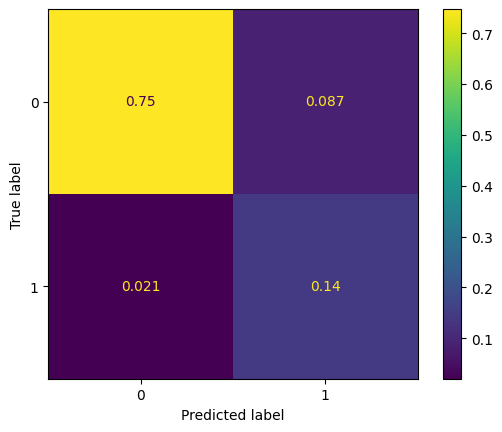

In [18]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, normalize='all')

**Save model**

Picke format.

In [19]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

---
### Test model

In [22]:
# Create test data for prediction
rand_rows = [83, 923, 543, 398, 729]
testAPI_data = X_test.iloc[rand_rows, :]
testAPI_data

,nombre_paquete,ciudad_agencia,nombre_tipo_habitacion,nombre_canal,nombre_estado
128166,0.8824,0.0464,0.2973,0.0548,0.0689
48627,0.1174,0.1699,0.2973,0.1359,0.6716
168278,0.8824,0.1699,0.2973,0.0633,0.0812
109583,0.1174,0.3009,0.0899,0.1630,0.6716
140574,0.8824,0.3009,0.0489,0.1630,0.0689


In [23]:
# Create csv file for testAPI_data
testAPI_data.to_csv('testAPI_data.csv', index=False)

In [25]:
# Load model
model = pickle.load(open('xgboost_model.pkl','rb'))

# Cargar datos de prueba
df_testAPI = pd.read_csv('testAPI_data.csv')

# Predecir bankrupt
pred = model.predict(df_testAPI)
pred

array([1, 0, 1, 0, 1])